In [ ]:
#| default_exp 11-label-matrix-augmented-input-trie-for-distilbert

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export
import os, pandas as pd, warnings, torch, pickle, numpy as np
from tqdm.auto import tqdm
from scipy import stats

import xclib.utils.sparse as xs

from xcai.basics import *
from xcai.models.MMM00X import DBT007, DBT008
from xcai.transform import AugmentMetaInputIdsTfm

comet_ml is installed but `COMET_API_KEY` is not set.


In [ ]:
#| export
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
#| export
dump_dir = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/11-label-matrix-augmented-input-trie-for-distilbert'

In [ ]:
#| export
fname = '/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/data/block.pkl'
with open(fname, 'rb') as f: block, test_dset = pickle.load(f)

# Generation

In [ ]:
#| export
mname = f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000'
model = DBT007.from_pretrained(mname, tn_targ=10_000, ig_tok=0)

Some weights of DBT007 were not initialized from the model checkpoint at /scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000 and are newly initialized: ['loss_fn.o']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#| export
args = XCLearningArguments(
    output_dir=f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K',
    generation_length_penalty=1.5,
    per_device_eval_batch_size=128,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
#| export
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## `meta-augmented trie`

In [ ]:
#| export
data_lbl = block.train.dset.data.data_lbl
lbl_lbl = data_lbl.T.dot(data_lbl).tocsr()
lbl_lbl.setdiag(1)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
#| export
lbl_toks = block.lbl_info['input_ids']
lbl_info = [o.indices.tolist() for o in lbl_lbl]

trie = Trie.from_list(lbl_toks, lbl_info)

  0%|          | 0/312330 [00:00<?, ?it/s]

In [ ]:
#| export
learn.tbs.trie = trie

In [ ]:
#| export
learn.tbs.n_bm = learn.args.generation_num_beams = 20

In [ ]:
o = learn.predict(test_dset)
display_metric(o.metrics)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200,loss,runtime,samples_per_second,steps_per_second
0,10.4,6.65,4.98,3.37,10.4,11.4739,12.0265,13.058,8.5923,8.8065,9.4459,11.698,8.5923,9.9913,10.7134,11.8486,10.0031,11.585,16.2331,22.7299,27.6943,36.6968,7.0555,353.1007,5.664,0.178


In [ ]:
pred_fname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/predictions/test_lbl_atrie-hlk_n-bm-20_n-samples-2000_seed-50.pth'
os.makedirs(os.path.dirname(pred_fname), exist_ok=True)
torch.save(o, pred_fname)

In [ ]:
#| export
o = learn.predict(block.test.dset)
print(o.metrics)

In [ ]:
#| export
pred_fname = f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/predictions/test_lbl_atrie-hlk_n-bm-20.pth'
os.makedirs(os.path.dirname(pred_fname), exist_ok=True)
torch.save(o, pred_fname)

In [ ]:
o

XCPredictionOutput(pred_idx=tensor([ 39908, 214276,  88840,  ..., 117626, 292992, 142001]), pred_ptr=tensor([ 600,  448, 2321,  ...,  355,  812,  103]), pred_score=tensor([-1.0248, -1.0248, -1.0248,  ..., -0.3543, -0.4384, -0.4384]), metrics={'test_loss': 7.055476665496826, 'test_P@1': 0.104, 'test_P@10': 0.03370000000000012, 'test_P@3': 0.06649999999999977, 'test_P@5': 0.04980000000000029, 'test_N@1': 0.10400000214576721, 'test_N@10': 0.13058030605316162, 'test_N@3': 0.11473865061998367, 'test_N@5': 0.12026500701904297, 'test_PSP@1': 0.08592265579098113, 'test_PSP@10': 0.11698006882020448, 'test_PSP@3': 0.08806547937798681, 'test_PSP@5': 0.0944594349894385, 'test_PSN@1': 0.08592265099287033, 'test_PSN@10': 0.11848550289869308, 'test_PSN@3': 0.09991305321455002, 'test_PSN@5': 0.10713402926921844, 'test_R@2': 0.10003124065831873, 'test_R@3': 0.11584986990843772, 'test_R@100': 0.2769429767596711, 'test_R@200': 0.3669681947634508, 'test_R@10': 0.162331260159278, 'test_R@50': 0.22729909890

### __Shortlist & Total recall__

All the numbers reported below are on a sample of 2000 points.

In [ ]:
s = get_tensor_statistics(o.pred_ptr);s

,mean,std,25,50,75
0,444.949005,340.45932,227.0,360.0,555.0


In [ ]:
r, rm = total_recall(o.pred_idx, o.pred_ptr, test_dset.data.data_lbl, test_dset.data.data_lbl_filterer) 
print(f'Total recall : {r*100:.3f}')

Total recall : 55.008


/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
r = get_tensor_statistics(torch.tensor(rm.sum(axis=1)).flatten()*rm.shape[0]*100); r

,mean,std,25,50,75
0,55.007782,43.182491,0.0,60.0,100.0


In [ ]:
data_rec = torch.tensor(rm.sum(axis=1)).flatten()

<matplotlib.collections.PathCollection>

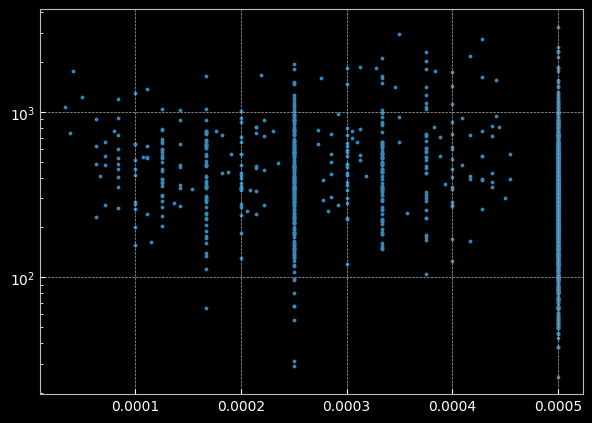

In [ ]:
import matplotlib.pyplot as plt

set_plot_defaults()
plt.figure(figsize=(7,5))
plt.yscale('log')
idx = torch.where(data_rec > 0)[0]
plt.scatter(data_rec[idx], o.pred_ptr[idx], s=5)

In [ ]:
stats.pearsonr(data_rec, o.pred_ptr), stats.spearmanr(data_rec, o.pred_ptr)

(PearsonRResult(statistic=-0.08760618504393618, pvalue=8.746673579622356e-05),
 SignificanceResult(statistic=-0.16413457259361677, pvalue=1.5145394695676285e-13))

# Representation

In [ ]:
args = XCLearningArguments(
    output_dir=f'{dump_dir}/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/',
    index_efs=200,
    representation_num_beams=200,
    generation_length_penalty=1.5,
    per_device_eval_batch_size=16,
    evaluation_strategy='steps',
    label_names=['lbl2data_idx'],
)

In [ ]:
bsz = max(args.per_device_train_batch_size, args.per_device_eval_batch_size)*torch.cuda.device_count()
model = DBT008.from_pretrained('sentence-transformers/msmarco-distilbert-base-v4', bsz=bsz, tn_targ=10_000, ig_tok=0)

Some weights of DBT008 were not initialized from the model checkpoint at sentence-transformers/msmarco-distilbert-base-v4 and are newly initialized: ['loss_fn.u', 'loss_fn.v']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from collections import OrderedDict

mname = f'/scratch/scai/phd/aiz218323/Projects/xc_nlg/outputs/05-metadata-augmented-input-and-trie-for-distilbert/ngame_v-3-100_(mapped)LF-WikiSeeAlsoTitles-320K/model_network.pkl'
m_state_dict, msd = OrderedDict(), torch.load(mname)
for k in msd:
    o = k.split('.')
    if o[0] == 'encoder': m_state_dict['distilbert.'+'.'.join(o[5:])] = msd[k]
model.load_state_dict(m_state_dict, strict=False)


_IncompatibleKeys(missing_keys=['loss_fn.u', 'loss_fn.v'], unexpected_keys=[])

In [ ]:
metric = PrecRecl(test_dset.n_lbl, test_dset.data.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
metric = PrecRecl(block.n_lbl, block.test.data_lbl_filterer, prop=block.train.dset.data.data_lbl,
                  pk=10, rk=200, rep_pk=[1, 3, 5, 10], rep_rk=[2, 3, 10, 50, 100, 200])

In [ ]:
learn = XCLearner(
    model=model, 
    args=args,
    data_collator=block.collator, 
    compute_metrics=metric,
)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## Reranking

In [ ]:
import torch.nn.functional as F

In [ ]:
data_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset)), dim=1)

  0%|          | 0/63 [00:00<?, ?it/s]

/scratch/scai/phd/aiz218323/Projects/xcai/xcai/losses.py:21: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(data_ptr, data_idx, scores, device=data_ptr.device)


In [ ]:
lbl_repr = F.normalize(learn.get_representation(learn.get_test_dataloader(test_dset.lbl_dset)), dim=1)

  0%|          | 0/9761 [00:00<?, ?it/s]

In [ ]:
pred = torch.load(f'{dump_dir}/distilbert-base-uncased_RB33-NAR-3+8-2_(mapped)LF-WikiSeeAlsoTitles-320K/checkpoint-190000/\
predictions/test_lbl_atrie-hlk_n-bm-20_n-smp-2000_seed-50.pth')

In [ ]:
from tqdm.auto import tqdm
sc,p = [],0
for q,d in tqdm(zip(pred.pred_ptr.cumsum(0),data_repr), total=data_repr.shape[0]):
    sc.append(d@lbl_repr[pred.pred_idx[p:q]].T);p=q
sc = torch.cat(sc)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
o = {
    'pred_idx': pred.pred_idx,
    'pred_ptr': pred.pred_ptr,
    'pred_score': pred.pred_score,
}
o['targ_idx'] = torch.tensor(test_dset.data.data_lbl.indices, dtype=torch.long)
o['targ_ptr'] = torch.tensor([o.getnnz() for o in test_dset.data.data_lbl])

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,10.2,6.733333,5.02,3.365,10.2,11.507574,12.048035,13.041331,8.359828,8.943754,9.525369,11.646053,8.359829,10.025511,10.725805,11.809041,10.052132,11.624828,16.228979,22.716458,27.678048,36.720532


In [ ]:
o['pred_score'] = sc

In [ ]:
m = metric(**o)

/scratch/scai/phd/aiz218323/anaconda3/envs/xc_nlg/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
with pd.option_context('display.max_columns', None):
    display(pd.DataFrame([m])[sorted_metric(m, order=['P', 'N', 'PSP', 'PSN'])] * 100)

,P@1,P@3,P@5,P@10,N@1,N@3,N@5,N@10,PSP@1,PSP@3,PSP@5,PSP@10,PSN@1,PSN@3,PSN@5,PSN@10,R@2,R@3,R@10,R@50,R@100,R@200
0,31.05,21.8,16.5,10.585,31.049999,30.675468,31.437054,33.572186,18.18226,21.958956,24.367917,29.537648,18.182259,20.804821,22.349995,24.808649,22.614061,27.169605,39.005147,50.02413,52.556195,53.92804
